In [54]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GEVMLE_ts

In [55]:
import pymc as pm
import pymc_experimental.distributions as pmx
import arviz as az

In [56]:
def load_daily_max_prcp(filename):
    df = pd.read_csv(filename,parse_dates=['valid'],usecols=['valid','station','precip_in'])
    df = df.rename(columns={'valid':'datetime'})
    df['date'] = df['datetime'].dt.date
    df['date'] = df['date'].astype('datetime64[ns]')
    df['time'] = df['datetime'].dt.time
    df = df.groupby(['date','station'])['precip_in'].max()
    return df.unstack('station')

In [57]:
df_NY_airports_hourly_max = load_daily_max_prcp('../NY_airports_hourly_prcp.csv')
df_NJ_airports_hourly_max = load_daily_max_prcp('../NJ_airports_hourly_prcp.csv')

In [58]:
# df_NY_counts = df_NY_airports_hourly_max.groupby(lambda x:x.year).count()
df_NY_airports_hourly_max = df_NY_airports_hourly_max.loc['1970-01-01':'2022-12-31',['ALB','BGM','BUF','JFK','LGA','ROC']]
df_NJ_airports_hourly_max = df_NJ_airports_hourly_max.loc['1970-01-01':'2022-12-31',['ACY','EWR']]


In [59]:
df_NY_region_hourly_max = df_NY_airports_hourly_max.join(df_NJ_airports_hourly_max, how='outer')
df_NY_region_annual_max = df_NY_region_hourly_max.groupby(lambda x:x.year).max()

In [60]:
params = {}

for station in df_NY_region_hourly_max:

    GEV_hourly = GEVMLE_ts()
    GEV_hourly.fit(df_NY_region_hourly_max[station].fillna(0.0))
    station_params = GEV_hourly.get_params()
    station_params['10y'] = GEV_hourly.return_level(10)
    station_params['100y'] = GEV_hourly.return_level(100)
    station_params['10yse'] = GEV_hourly.return_level_se(10).item()
    station_params['100yse'] = GEV_hourly.return_level_se(100).item()
    params[station] = station_params

In [61]:
pd.DataFrame(params).T

,mu,sigma,xi,10y,100y,10yse,100yse
ALB,0.846779,0.213258,0.167573,1.429709,2.325102,0.108171,0.428934
BGM,0.744401,0.246030,0.262252,1.498935,2.940999,0.155321,0.746398
BUF,0.791386,0.247622,0.300614,1.587897,3.251284,0.171864,0.913788
JFK,0.984831,0.323643,0.141936,1.842901,3.085250,0.155777,0.609815
LGA,0.999008,0.340878,-0.017883,1.750878,2.504331,0.112338,0.321120
ROC,0.743930,0.254333,0.118664,1.399974,2.300215,0.116342,0.434068
ACY,0.960162,0.392489,0.163698,2.028050,3.653751,0.200082,0.833115
EWR,1.010923,0.313233,0.165943,1.865461,3.173123,0.161646,0.696984


In [62]:
# df_hourly = pd.read_csv('../ewr_hourly_prcp.csv',parse_dates=['valid'],usecols=['valid','precip_in'])
# df_hourly = df_hourly.rename(columns={'valid':'datetime'})
# df_hourly['date'] = df_hourly['datetime'].dt.date
# df_hourly['time'] = df_hourly['datetime'].dt.time

In [63]:
def ts_interpolate(ts):
    dt_start = ts.index.min()
    dt_end = ts.index.max()
    dt_range = pd.date_range(dt_start,dt_end)
    return ts.reindex(dt_range,fill_value=0.0)

In [64]:
#max hourly precipitation per day
# ts_hourly_max = df_hourly.groupby(['date'])['precip_in'].max()
# ts_hourly_max = ts_interpolate(ts_hourly_max)
ts_hourly_max = df_NY_region_hourly_max['LGA']

In [65]:
ts_blockmaxima = ts_hourly_max.loc['1949-01-01':'2022-12-31'].copy() #we only want full years.
ts_blockmaxima = ts_blockmaxima.to_frame("value")
ts_blockmaxima["year"] = ts_blockmaxima.index.year
ts_blockmaxima = ts_blockmaxima.groupby("year")["value"].max()

In [66]:
GEV_hourly = GEVMLE_ts()
GEV_hourly.fit(ts_hourly_max)
GEV_hourly.get_params()

{'mu': 0.9990079446453204,
 'sigma': 0.3408777601187529,
 'xi': -0.01788283312581454}

In [67]:

GEV_hourly.return_level(10)

1.7508779201598919

In [68]:
data = ts_blockmaxima.values

# return_periods = GEV_hourly._return_periods(n=50)
return_periods = np.logspace(0.01,2, num=100)
p = 1/return_periods

with pm.Model() as model:
    # Priors
    μ = pm.Normal("μ", mu=1.0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.5)
    # ξ = pm.Normal("ξ", mu=0.0, sigma=0.1)
    # ξ = pm.TruncatedNormal("ξ", mu=0, sigma=0.2, lower=-0.5, upper=0.5)
    ξ = pm.HalfNormal("ξ", sigma=0.1)
 

    # Estimation
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=data)
    # Return level
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

In [69]:
idata = pm.sample_prior_predictive(samples=1000, model=model)

Sampling: [gev, μ, ξ, σ]


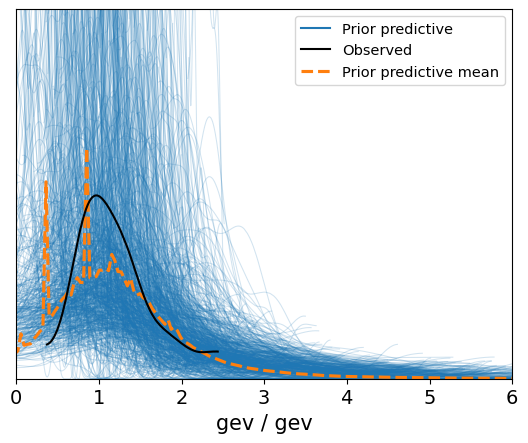

In [70]:
az.plot_ppc(idata, group="prior")
ax = plt.gca()
ax.set_xlim([0, 6])
ax.set_ylim([0, 2]);

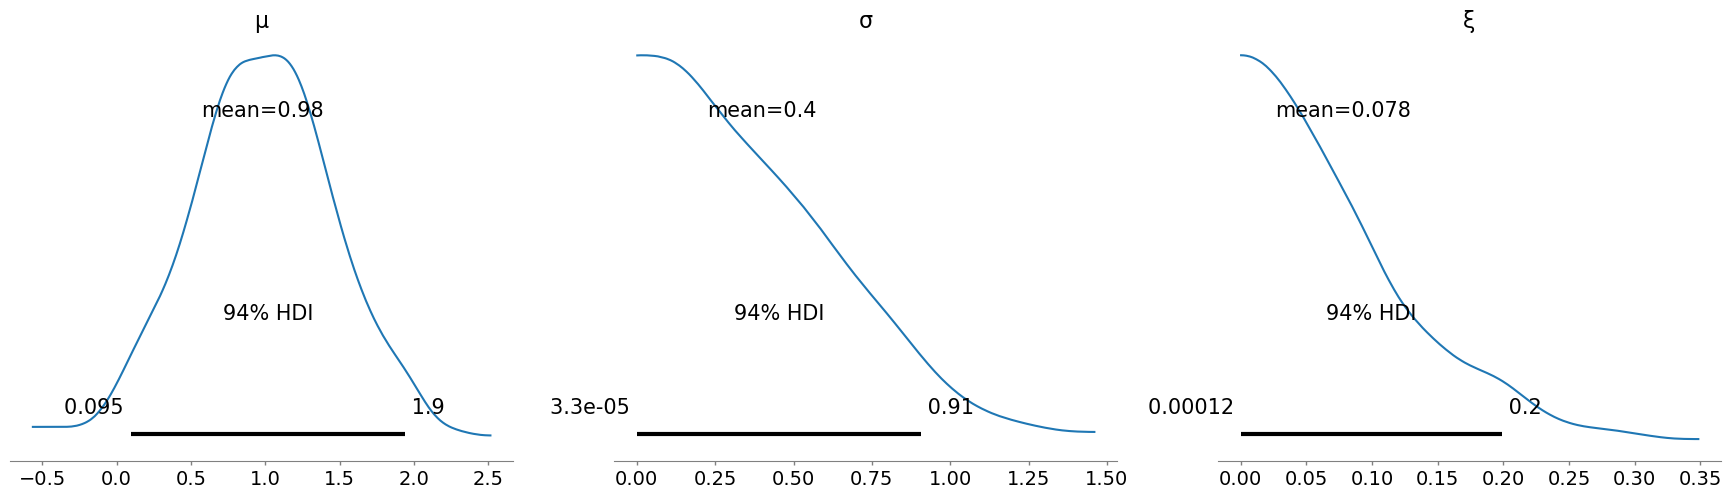

In [71]:
az.plot_posterior(
    idata, group="prior", var_names=["μ", "σ", "ξ"]
);

In [72]:
with model:
    trace = pm.sample(
        5000,
        # cores=4,
        # chains=4,
        # tune=2000,
        # initvals={"μ": -0.5, "σ": 1.0, "ξ": -0.1},
        target_accept=0.98,
    )
# add trace to existing idata object
idata.extend(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


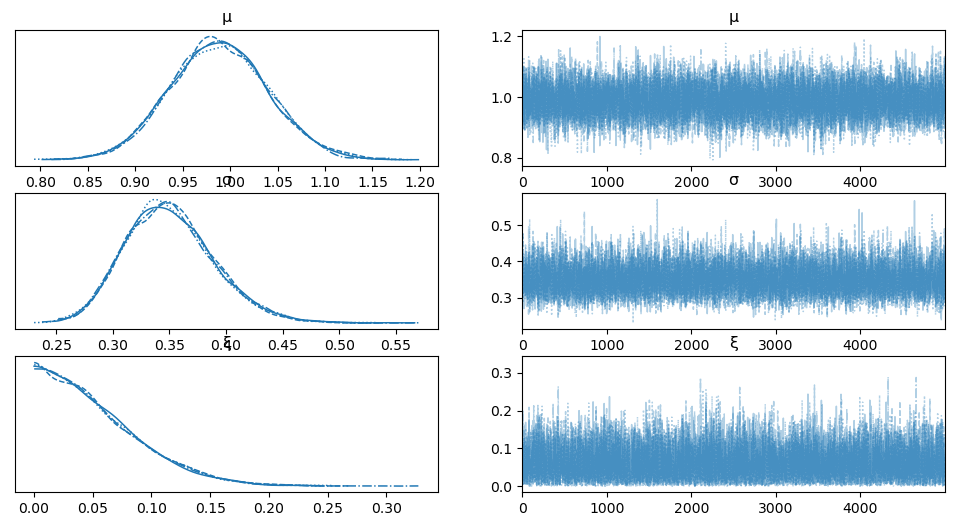

In [73]:
az.plot_trace(idata, var_names=["μ", "σ", "ξ"]);

In [74]:
# az.plot_trace(idata, var_names=["z_p"], figsize=(12, 12));

In [75]:
# az.plot_posterior(idata, hdi_prob=0.95, var_names=["z_p"]);

In [76]:
z_p_summary = az.summary(idata,var_names=['z_p'],hdi_prob= 0.95)
z_p_summary.index=return_periods

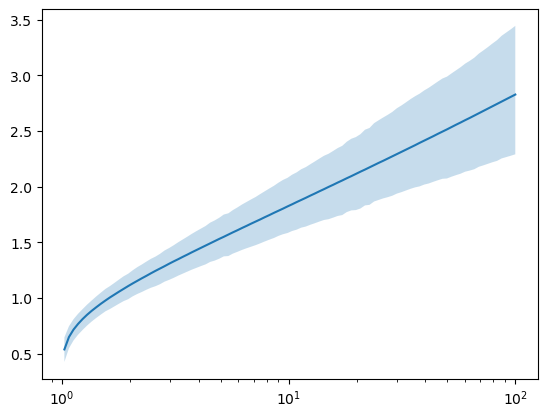

In [77]:
z_p_summary['mean'].plot()
plt.fill_between(z_p_summary.index,z_p_summary['hdi_2.5%'].values,z_p_summary['hdi_97.5%'].values,alpha=0.25)
plt.xscale("log")

In [78]:
z_p_summary


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1.023293,0.538,0.057,0.426,0.646,0.001,0.000,13278.0,9821.0,1.0
1.071769,0.649,0.051,0.548,0.746,0.000,0.000,12534.0,10162.0,1.0
1.122541,0.716,0.049,0.618,0.809,0.000,0.000,11744.0,9785.0,1.0
1.175718,0.767,0.048,0.670,0.858,0.000,0.000,10898.0,9630.0,1.0
1.231414,0.811,0.048,0.713,0.900,0.000,0.000,10264.0,9284.0,1.0
...,...,...,...,...,...,...,...,...,...
83.099031,2.744,0.288,2.232,3.317,0.003,0.002,9761.0,10802.0,1.0
87.035608,2.765,0.293,2.254,3.356,0.003,0.002,9772.0,10760.0,1.0
91.158670,2.786,0.298,2.266,3.385,0.003,0.002,9781.0,10828.0,1.0
95.477050,2.807,0.303,2.278,3.414,0.003,0.002,9791.0,10766.0,1.0


In [79]:
GEV_hourly.return_level(100), GEV_hourly.return_level_se(100)

(2.504330967074927, array(0.32112048))

In [80]:
az.summary(idata,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.989,0.052,0.888,1.091,0.001,0.0,8704.0,10133.0,1.0
σ,0.350,0.039,0.277,0.429,0.000,0.0,9459.0,9951.0,1.0
ξ,0.053,0.041,0.000,0.133,0.000,0.0,6481.0,4617.0,1.0


In [81]:
GEV_hourly.get_params()

{'mu': 0.9990079446453204,
 'sigma': 0.3408777601187529,
 'xi': -0.01788283312581454}